Test accuracy: 61.07784431137725 %
Confusion Matrix:
[[123   3   1  41]
 [  9  85  58   5]
 [  5  86  78   6]
 [ 40   3   3 122]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       168
           1       0.48      0.54      0.51       157
           2       0.56      0.45      0.50       175
           3       0.70      0.73      0.71       168

    accuracy                           0.61       668
   macro avg       0.61      0.61      0.61       668
weighted avg       0.61      0.61      0.61       668

Test accuracy: 61.08%
Micro-average precision: 0.6108
Micro-average recall: 0.6108
Micro-average F1-score: 0.6108
Test accuracy: 61.08%
Macro-average precision: 0.6084
Macro-average recall: 0.6114
Macro-average F1-score: 0.6077


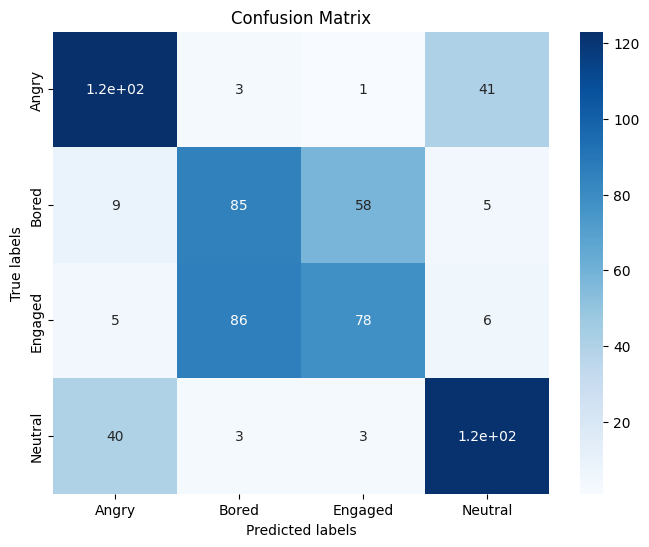

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class MultiLayerFCNet(nn.Module):
    def __init__(self,input_size, hidden_size, output_size):
        super().__init__()

        self.layer1=nn.Conv2d(3,32,3,padding=1,stride=1)
        self.B1 = nn.BatchNorm2d(32)
        self.layer2 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.B2 = nn.BatchNorm2d(32)
        self.Maxpool=nn.MaxPool2d(2)
        self.layer3 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.B3 = nn.BatchNorm2d(64)
        self.layer4 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.B4 = nn.BatchNorm2d(64)
        self.dropout = nn.Dropout(0.5)
        
        # New layers
        # self.layer5 = nn.Conv2d(64, 128, 4, padding=1, stride=1)
        # self.B5 = nn.BatchNorm2d(128)
        # self.layer6 = nn.Conv2d(128, 128, 4, padding=1, stride=1)
        # self.B6 = nn.BatchNorm2d(128)
        # self.layer7 = nn.Conv2d(128, 256, 4, padding=1, stride=1)
        # self.B7 = nn.BatchNorm2d(256)
        # self.layer8 = nn.Conv2d(256, 256, 4, padding=1, stride=1)
        # self.B8 = nn.BatchNorm2d(256)
        
        # Calculate the size for the fully connected layer after additional max-pooling layers
        # Assuming two max-pooling operations in the existing layers
        self.fc_size = 64 * 12 * 12   # Now this is 256 * 3 * 3
        self.fc = nn.Linear(self.fc_size, output_size)

    def forward(self, x):
        # Pass through existing layers
        x = F.leaky_relu(self.B1(self.layer1(x)))
        x = self.Maxpool(F.leaky_relu(self.B2(self.layer2(x))))
        x = F.leaky_relu(self.B3(self.layer3(x)))
        x = self.Maxpool(F.leaky_relu(self.B4(self.layer4(x))))
        
        # Pass through new layers
        # x = F.leaky_relu(self.B5(self.layer5(x)))
        # x = F.leaky_relu(self.B6(self.layer6(x)))
        # x = self.Maxpool(F.leaky_relu(self.B7(self.layer7(x))))
        # x = self.Maxpool(F.leaky_relu(self.B8(self.layer8(x))))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        return self.fc(x)
    

input_size = 3 * 48 * 48  # 1 channels, 48x48 image size
hidden_size = 50  # Number of hidden units
output_size = 4  # Number of output classes 4

# Load the saved model weights
state_dict = torch.load('./model/model_variant1.pth')

# Adjust the keys
new_state_dict = {k[len("module."):]: v for k, v in state_dict.items()}

model = MultiLayerFCNet(input_size, hidden_size, output_size)

# Wrap the model with nn.DataParallel if using multiple GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the adjusted state dictionary
model.load_state_dict(new_state_dict)

# Set the model to evaluation mode
model = model.to(device)
model.eval()

# Load the test dataset from dataset_split/Test

# YOUR CODE HERE
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor()
])

test_dataset = ImageFolder('./dataset/Test', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# YOUR CODE HERE
# Calculate the test accuracy

# YOUR CODE HERE
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy()) 
        all_labels.extend(labels.cpu().numpy())

print('Test accuracy: {} %'.format(100 * correct / total))
# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(all_labels, all_preds)

# Display the classification report
print("\nClassification Report:")
print(class_report)

accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro')

# Display results
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Micro-average precision: {precision:.4f}')
print(f'Micro-average recall: {recall:.4f}')
print(f'Micro-average F1-score: {f1_score:.4f}')

precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')

# Display results
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Macro-average precision: {precision:.4f}')
print(f'Macro-average recall: {recall:.4f}')
print(f'Macro-average F1-score: {f1_score:.4f}')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



# Define class labels
classes = ['Angry', 'Bored', 'Engaged', 'Neutral']

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes)

# Add labels, title, and display the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
